# Expérimentation RAG

In [1]:
import pandas as pd
import plotly.express as px

In [113]:
df = pd.read_excel("eval_resultats.xlsx")

In [58]:
df

,PLU,Indicateur,N° indicateur,Zone,id,Label section,Condition,chunk_size,chunk_overlap,LLM,Pertinence retriever,Exactitude LLM,Hallucination,Corrélation,Temps ingestion,Temps retriever,Temps LLM,Temps total
0,plu_1,Hauteur,1,U,UH1,U1,1,1024,0,Llama2,0,0,0,1,130.80,21.60,100.80,253.20
1,plu_1,Hauteur,1,U,UH1,U1,2,1024,0,Mistral 7B,0,0,0,1,132.00,47.40,395.40,574.80
2,plu_1,Hauteur,1,U,UH1,U1,3,1024,20,Llama2,0,0,0,1,131.40,49.80,276.00,457.20
3,plu_1,Hauteur,1,U,UH1,U1,4,1024,20,Mistral 7B,0,0,1,1,130.20,43.80,409.20,583.20
4,plu_1,Hauteur,1,U,UH1,U1,5,2048,0,Llama2,1,1,0,1,154.20,0.00,275.40,429.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,plu_4,Emprise,2,AU,AUE2,AUE,8,2048,20,Mistral 7B,0,0,0,1,163.30,0.68,548.40,712.38
380,plu_4,Emprise,2,AU,AUE2,AUE,9,4096,0,Llama2,1,1,0,1,52.35,0.06,317.02,369.43
381,plu_4,Emprise,2,AU,AUE2,AUE,10,4096,0,Mistral 7B,1,1,0,1,50.63,0.69,276.27,327.59
382,plu_4,Emprise,2,AU,AUE2,AUE,11,4096,20,Llama2,1,1,0,1,43.39,14.60,391.24,449.23


In [5]:
df.columns

Index(['PLU', 'Indicateur', 'N° indicateur', 'Zone', 'id', 'Label section',
       'Condition', 'chunk_size', 'chunk_overlap', 'LLM',
       'Pertinence retriever', 'Exactitude LLM', 'Hallucination',
       'Corrélation', 'Temps  ingestion', 'Temps retriever', 'Temps LLM',
       'Temps total'],
      dtype='object')

In [114]:
df.rename(columns={'Temps  ingestion': 'Temps ingestion'}, inplace=True)

In [115]:
df['LLM'] = df['LLM'].replace({
    'Mistral': 'Mistral 7B',
    'Mistral7B': 'Mistral 7B'
})

## Pertinence du retriever contextuel

In [60]:
(df['Pertinence retriever'].sum() / len(df['Pertinence retriever'])) * 100

38.80208333333333

In [107]:
sum_pertinence_by_condition = df.groupby('Condition')['Pertinence retriever'].sum()
rate_pertinence_by_condition = (sum_pertinence_by_condition / 32) * 100
rate_pertinence_by_condition

Condition
1      9.375
2      9.375
3      9.375
4      6.250
5     28.125
6     21.875
7     31.250
8     31.250
9     87.500
10    81.250
11    78.125
12    71.875
Name: Pertinence retriever, dtype: float64

In [108]:
condition_labels = {
    1: '1024 - 0 - llama',
    2: '1024 - 0 - mistral',
    3: '1024 - 20 - llama',
    4: '1024 - 20 - mistral',
    5: '2048 - 0 - llama',
    6: '2048 - 0 - mistral',
    7: '2048 - 20 - llama',
    8: '2048 - 20 - mistral',
    9: '4096 - 0 - llama',
    10: '4096 - 0 - mistral',
    11: '4096 - 20 - llama',
    12: '4096 - 20 - mistral'
}

data = {
    'Condition': rate_pertinence_by_condition.index,
    'Pertinence (%)': rate_pertinence_by_condition.values,
    'Texte Condition': [condition_labels[c] for c in rate_pertinence_by_condition.index]
}

df = pd.DataFrame(data)

fig = px.bar(df, x='Pertinence (%)', y='Texte Condition', orientation='h',
             title='Pertinence par condition',
             labels={'Pertinence (%)': 'Pertinence (%)', 'Condition': 'Condition'},
             color='Pertinence (%)',
             color_continuous_scale='Viridis')

fig.update_layout(
    plot_bgcolor='white',
    xaxis_title='Pertinence (%)',
    yaxis_title='Condition',
    xaxis=dict(showline=True, showgrid=True, showticklabels=True, linecolor='black', linewidth=1),
    yaxis=dict(tickmode='linear', showline=True, showgrid=True, showticklabels=True, linecolor='black', linewidth=1),
    title_font_size=20,
    title_x=0.5,
    title_xanchor='center',
    width=900,
    height=600
)
fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')
fig.show()

In [44]:
sum_pertinence_by_plu = df.groupby(['PLU', 'chunk_size'])['Pertinence retriever'].sum()

PLU    chunk_size
plu_1  1024           3
       2048          17
       4096          25
plu_2  1024           4
       2048          10
       4096          26
plu_3  1024           4
       2048           8
       4096          24
plu_4  1024           0
       2048           1
       4096          27
Name: Pertinence retriever, dtype: int64

In [61]:
df_grouped = sum_pertinence_by_plu.reset_index()
df_grouped['chunk_size'] = df_grouped['chunk_size'].astype('category')
custom_colors = {1024: 'yellow', 2048: 'green', 4096: 'darkblue'}

fig = px.bar(df_grouped, 
             x='PLU', 
             y='Pertinence retriever', 
             color='chunk_size', 
             barmode='group',
             labels={'Pertinence retriever': 'Nombre de contextes pertinents', 'chunk_size': 'Chunk Size', 'PLU': 'PLU'},
             color_discrete_map=custom_colors)

fig.update_layout(
    plot_bgcolor='white',
    width=900,
    height=600
)
fig.show()

In [63]:
sum_pertinence_by_indicator = df.groupby('Indicateur')['Pertinence retriever'].sum()
rate_pertinence_by_indicator = (sum_pertinence_by_indicator / 192) * 100
rate_pertinence_by_indicator

Indicateur
Emprise    27.083333
Hauteur    50.520833
Name: Pertinence retriever, dtype: float64

In [62]:
sum_pertinence_by_indic_and_cond = df.groupby(['Indicateur', 'chunk_size'])['Pertinence retriever'].sum()
sum_pertinence_by_indic_and_cond

Indicateur  chunk_size
Emprise     1024           1
            2048           9
            4096          42
Hauteur     1024          10
            2048          27
            4096          60
Name: Pertinence retriever, dtype: int64

## Reproductibilité du retriever

In [67]:
df.groupby(['LLM'])['Pertinence retriever'].sum()

LLM
Llama2        78
Mistral 7B    71
Name: Pertinence retriever, dtype: int64

## Exactitude du LLM

In [68]:
(df['Exactitude LLM'].sum() / len(df['Exactitude LLM'])) * 100

39.0625

In [69]:
sum_accuracy_by_condition = df.groupby('Condition')['Exactitude LLM'].sum()
rate_accuracy_by_condition = (sum_accuracy_by_condition / 32) * 100
rate_accuracy_by_condition

Condition
1     12.500
2      9.375
3      9.375
4      6.250
5     34.375
6     21.875
7     31.250
8     31.250
9     87.500
10    81.250
11    71.875
12    71.875
Name: Exactitude LLM, dtype: float64

In [74]:
data = {
    'Condition': rate_accuracy_by_condition.index,
    'Pertinence (%)': rate_accuracy_by_condition.values,
    'Texte Condition': [condition_labels[c] for c in rate_accuracy_by_condition.index]
}

df = pd.DataFrame(data)

fig = px.bar(df, x='Pertinence (%)', y='Texte Condition', orientation='h',
             title='Pertinence par condition',
             labels={'Pertinence (%)': 'Pertinence (%)', 'Condition': 'Condition'},
             color='Pertinence (%)',
             color_continuous_scale='Viridis')

fig.update_layout(
    plot_bgcolor='white',
    xaxis_title='Pertinence (%)',
    yaxis_title='Condition',
    xaxis=dict(showline=True, showgrid=True, showticklabels=True, linecolor='black', linewidth=1),
    yaxis=dict(tickmode='linear', showline=True, showgrid=True, showticklabels=True, linecolor='black', linewidth=1),
    title_font_size=20,
    title_x=0.5,
    title_xanchor='center',
    width=900,
    height=600
)
fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')
fig.show()

In [66]:
sum_accuracy_by_plu = df.groupby('PLU')['Exactitude LLM'].sum()
rate_accuracy_by_plu = (sum_accuracy_by_plu / 96) * 100
rate_accuracy_by_plu

PLU
plu_1    48.958333
plu_2    41.666667
plu_3    36.458333
plu_4    29.166667
Name: Exactitude LLM, dtype: float64

In [67]:
sum_accuracy_by_indicator = df.groupby('Indicateur')['Exactitude LLM'].sum()
rate_accuracy_by_indicator = (sum_accuracy_by_indicator / 192) * 100
rate_accuracy_by_indicator

Indicateur
Emprise    27.604167
Hauteur    50.520833
Name: Exactitude LLM, dtype: float64

In [82]:
sum_accuracy_by_llm = df.groupby('LLM')['Exactitude LLM'].sum()
rate_accuracy_by_llm = (sum_accuracy_by_llm / 192) * 100
rate_accuracy_by_llm

LLM
Llama2        41.145833
Mistral 7B    36.979167
Name: Exactitude LLM, dtype: float64

## Corrélation entre pertinence du retriever et exactitude du LLM

In [72]:
(df['Corrélation'].sum() / len(df['Corrélation'])) * 100

98.4375

## Hallucinations

In [68]:
(df['Hallucination'].sum() / len(df['Hallucination'])) * 100

17.447916666666664

In [71]:
sum_hallu_by_llm = df.groupby('LLM')['Hallucination'].sum()
rate_hallu_by_llm = (sum_hallu_by_llm / 192) * 100
rate_hallu_by_llm

LLM
Llama2        20.312500
Mistral 7B    14.583333
Name: Hallucination, dtype: float64

## Temps de traitement

### Temps total du pipeline

In [102]:
df['Temps total'].mean() / 60

7.817920572916667

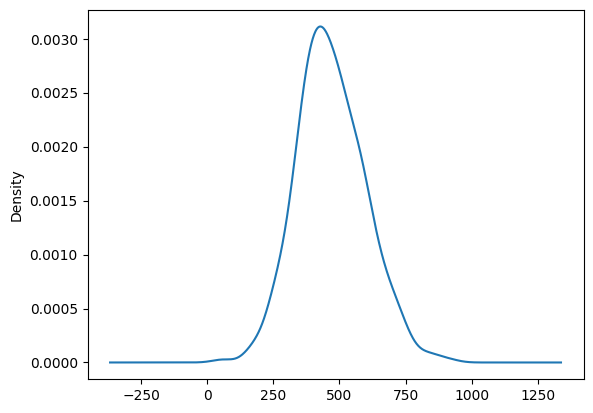

In [103]:
df['Temps total'].plot(kind='density');

In [104]:
time_by_condition = df.groupby('Condition')['Temps total'].mean().round(2)

In [111]:
df_time_by_condition = time_by_condition.reset_index()

fig = px.bar(
    df_time_by_condition, 
    x=condition_labels, 
    y='Temps total',
    labels={'Condition': 'Condition', 'Temps total': 'Temps total'},
    title='Temps total moyen par condition',
    text='Temps total',
    height=600,
    width=900,
    color_discrete_sequence=['darkblue']
)

fig.update_layout(
    xaxis_title='Condition',
    yaxis_title='Temps total (secondes)',
    plot_bgcolor='white',
    xaxis=dict(tickmode='linear')
)

fig.show()

### Temps d'ingestion (extraction texte + split + embedding + vector store)

In [41]:
df['Temps ingestion'].mean() / 60

1.9764791666666666

In [42]:
df.groupby('Condition')['Temps ingestion'].mean()

Condition
1     131.6750
2     150.4750
3     148.0250
4     144.8800
5     162.7750
6     151.5325
7     150.5000
8     189.3250
9      51.6500
10     54.9550
11     44.1950
12     43.0775
Name: Temps ingestion, dtype: float64

In [44]:
df.groupby('chunk_size')['Temps ingestion'].mean()

chunk_size
1024    143.763750
2048    163.533125
4096     48.469375
Name: Temps ingestion, dtype: float64

In [45]:
df.groupby('chunk_overlap')['Temps ingestion'].mean()

chunk_overlap
0     117.177083
20    120.000417
Name: Temps ingestion, dtype: float64

### Temps du retriever

In [46]:
df['Temps retriever'].mean() / 60

0.10411675347222224

In [47]:
df.groupby('Condition')['Temps retriever'].mean()

Condition
1      2.361562
2      5.904688
3      6.062187
4     11.784688
5      9.372813
6     14.908125
7      4.268438
8      7.753125
9      4.091563
10     3.449062
11     2.505000
12     2.502813
Name: Temps retriever, dtype: float64

In [48]:
df.groupby('chunk_size')['Temps retriever'].mean()

chunk_size
1024    6.528281
2048    9.075625
4096    3.137109
Name: Temps retriever, dtype: float64

### Temps de réponse du LLM

In [49]:
df['Temps LLM'].mean() / 60

5.737324652777777

In [119]:
time_llm_by_condition = df.groupby('Condition')['Temps LLM'].mean().round(2)

In [120]:
df_time_llm_by_condition = time_llm_by_condition.reset_index()

fig = px.bar(
    df_time_llm_by_condition, 
    x=condition_labels, 
    y='Temps LLM',
    labels={'Condition': 'Condition', 'Temps LLM': 'Temps LLM'},
    title='Temps de réponse moyen du LLM par condition',
    text='Temps LLM',
    height=600,
    width=900,
    color_discrete_sequence=['darkblue']
)

fig.update_layout(
    xaxis_title='Condition',
    yaxis_title='Temps de réponse moyen du LLM (secondes)',
    plot_bgcolor='white',
    xaxis=dict(tickmode='linear')
)

fig.show()

In [51]:
df.groupby('chunk_size')['Temps LLM'].mean()

chunk_size
1024    295.744453
2048    369.976797
4096    366.997187
Name: Temps LLM, dtype: float64

In [121]:
df.groupby('LLM')['Temps LLM'].mean()

LLM
Llama2        340.088333
Mistral 7B    348.390625
Name: Temps LLM, dtype: float64